In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import mpl_interactions as pli

In [2]:
import fastcat as fc

In [3]:

# Read the text file
with open('schneider_material_conv.txt', 'r') as f:
    lines = f.readlines()
# remove the newline character
lines = [line.strip() for line in lines]
# remove empty lines
lines = [line for line in lines if line]
# remove comments
lines = [line for line in lines if not line.startswith('#')]
# Parse the lines into variables
HU_sections = list(map(int, lines[0].split('=')[1].split()[1:]))
density_offset = list(map(float, lines[1].split('=')[1].split()[1:]))
density_factor = list(map(float, lines[2].split('=')[1].split()[1:]))
density_factor_offset = list(map(float, lines[3].split('=')[1].split()[1:]))
elements = [el.split('"')[1] for el in lines[4].split('=')[1].split()[1:]]
HU_to_material_sections = list(map(int, lines[5].split('=')[1].split()[1:]))
materials_weight = [list(map(float, line.split('=')[1].split()[1:])) for line in lines[6:-1]]
density_correction = list(map(float, lines[-1].split('=')[1].split()[1:-1]))

# Define the function to decompose a DICOM array into a binary array of 25 materials
def decompose_dicom(dicom_array):
    # Calculate the density array
    arr_clipped = np.clip(dicom_array, -1000, 2995)
    HU_vals = np.arange(-1000, 2996)
    density_map = np.zeros_like(density_correction)
    for ii, HU_section in enumerate(HU_sections[:-1] ):
        # print(ii,HU_sections[ii])
        # Formula: Density = (Offset + (Factor*(FactorOffset + HU[-1000,2995] ))) * DensityCorrection
        density_map[HU_sections[ii] + 1000:HU_sections[ii+1]+ 1000] = (
            density_offset[ii] + 
            (density_factor[ii] * (density_factor_offset[ii] +
                                   HU_vals[HU_sections[ii] + 1000:
                                           HU_sections[ii+1]+ 1000]))) * density_correction[HU_sections[ii] + 1000:
                                           HU_sections[ii+1]+ 1000]

    # Initialize the binary array
    binary_array = np.zeros_like(arr_clipped, dtype=int)

    # # Decompose the DICOM array into the binary array
    for i in range(25):
        inds = (HU_to_material_sections[i] <= arr_clipped) & (arr_clipped < HU_to_material_sections[i+1])
        binary_array[inds] = i

    # Map the HU values to density using the density map
    arr_clipped = arr_clipped + 1000

    # Map the HU values to the density values using the density map as a lookup table
    density_array = density_map[arr_clipped]

    return density_map, binary_array, density_array

In [5]:
# Calculate average densities for each material
average_densities = [np.mean(density_map[HU_to_material_sections[i]+1000:HU_to_material_sections[i+1]+1000]) for i in range(len(HU_to_material_sections[:-1]))]
# Calculate names for each material
names = [f"SchneiderMaterialsWeight{i+1}" for i in range(len(materials_weight))]
print(names, elements, materials_weight, 'material_file.txt', average_densities)
# Call the function to make material files

fc.utils.make_material_mu_files_schneider_all(names, elements, materials_weight, 'brain', average_densities)
fc.utils.write_range_file('brain',names)
fc.utils.write_mhd_file('brain',binary_array.astype(float), numpyOrigin, np.abs(numpySpacing).max(axis=0))


NameError: name 'density_map' is not defined

In [8]:
fc.utils.write_mhd_file('brain',binary_array.astype(float), numpyOrigin, np.abs(numpySpacing).max(axis=0))

NameError: name 'binary_array' is not defined

array([0.761719, 0.761719, 1.25    ])

In [87]:
elements, materials_weight[-1], average_densities[-1]

(['Hydrogen',
  'Carbon',
  'Nitrogen',
  'Oxygen',
  'Magnesium',
  'Phosphorus',
  'Sulfur',
  'Chlorine',
  'Argon',
  'Calcium',
  'Sodium',
  'Potassium',
  'Titanium'],
 [13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 4.552485)

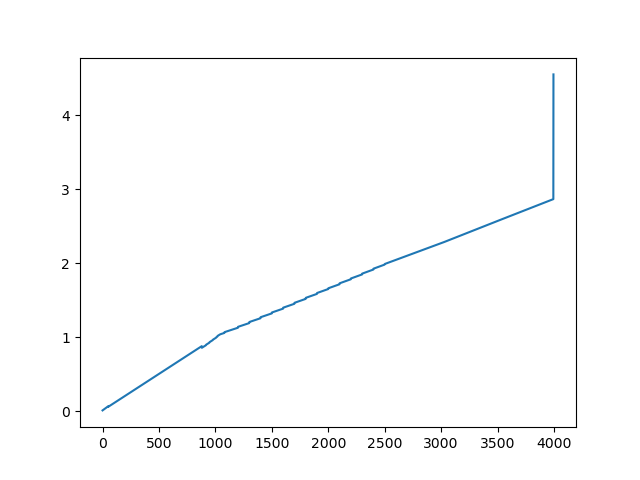

In [81]:
plt.figure()
plt.plot(density_map)

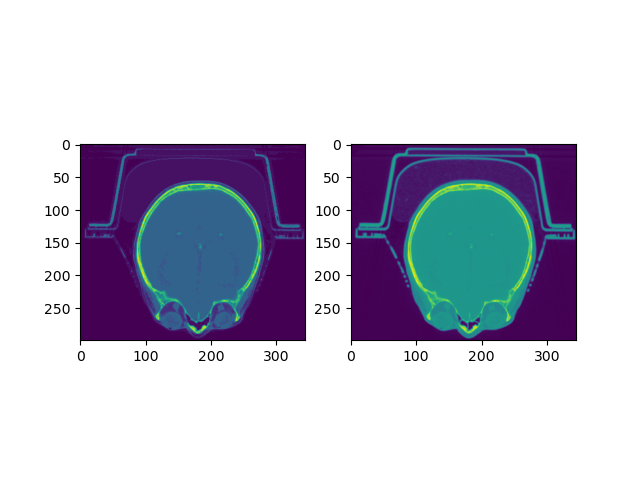

In [92]:
# load the nrrd file
import nrrd
# Read the nrrd file
data, header = nrrd.read('data/smaller_volume_CNS_CT.nrrd')

numpyOrigin = header['space origin']
numpySpacing = header['space directions']
# Decompose the DICOM array
density_map, binary_array, density_array = decompose_dicom(data)

# fc.utils.

# plt.figure()
# plt.plot(density_map)

plt.figure()
plt.subplot(121)
cont = pli.hyperslicer(binary_array.T)
plt.subplot(122)
cont2 = pli.hyperslicer(density_array.T,controls=cont)

In [9]:
fc.utils.nrrd_to_mhd('data/smaller_volume_CNS_CT.nrrd')

[2024-03-20 15:31:30,369] {utils.py:319} INFO - Loading density data from file
[2024-03-20 15:31:30,374] {utils.py:569} INFO -     Saved SchneiderMaterialsWeight1 atten to file in data/mu_over_rho/SchneiderMaterialsWeight1.csv
[2024-03-20 15:31:30,375] {utils.py:319} INFO - Loading density data from file
[2024-03-20 15:31:30,378] {utils.py:569} INFO -     Saved SchneiderMaterialsWeight2 atten to file in data/mu_over_rho/SchneiderMaterialsWeight2.csv
[2024-03-20 15:31:30,379] {utils.py:319} INFO - Loading density data from file
[2024-03-20 15:31:30,383] {utils.py:569} INFO -     Saved SchneiderMaterialsWeight3 atten to file in data/mu_over_rho/SchneiderMaterialsWeight3.csv
[2024-03-20 15:31:30,384] {utils.py:319} INFO - Loading density data from file
[2024-03-20 15:31:30,389] {utils.py:569} INFO -     Saved SchneiderMaterialsWeight4 atten to file in data/mu_over_rho/SchneiderMaterialsWeight4.csv
[2024-03-20 15:31:30,389] {utils.py:319} INFO - Loading density data from file
[2024-03-20 1

In [64]:
# Print all the variables and their lengths
print(HU_sections, len(HU_sections))
print(density_offset, len(density_offset))
print(density_factor, len(density_factor))
print(density_factor_offset, len(density_factor_offset))
print(elements, len(elements))

[-1000, -98, 15, 23, 101, 2001, 2995, 2996] 8
[0.00121, 1.018, 1.03, 1.003, 1.017, 2.201, 4.54] 7
[0.001029700665188, 0.000893, 0.0, 0.001169, 0.000592, 0.0005, 0.0] 7
[1000.0, 0.0, 1000.0, 0.0, 0.0, -2000.0, 0.0] 7
['Hydrogen', 'Carbon', 'Nitrogen', 'Oxygen', 'Magnesium', 'Phosphorus', 'Sulfur', 'Chlorine', 'Argon', 'Calcium', 'Sodium', 'Potassium', 'Titanium'] 13


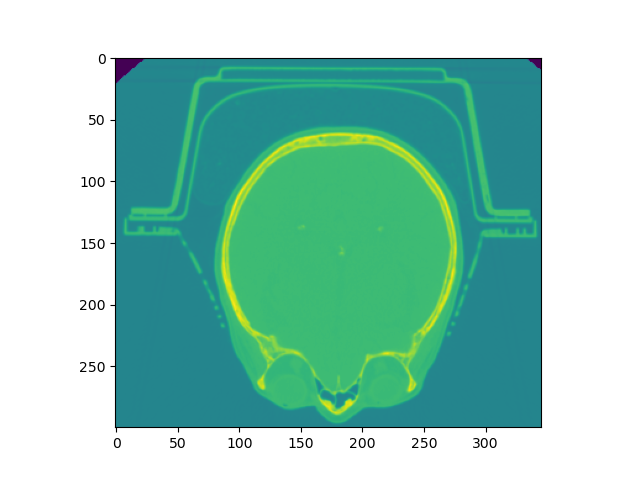

In [24]:
plt.figure()
pli.hyperslicer(data.T)

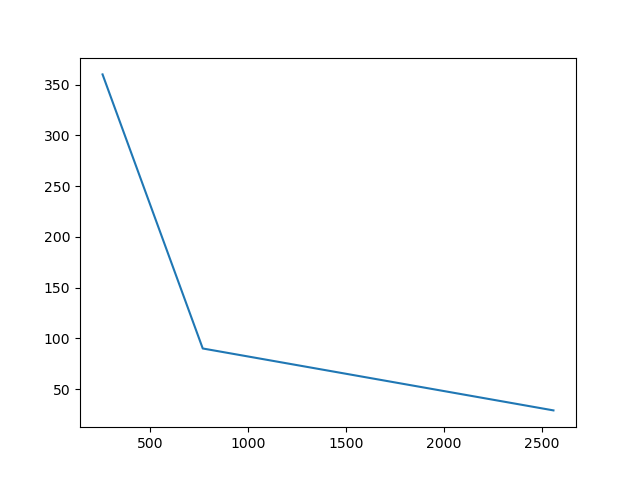

In [19]:
plt.figure()
plt.plot([256,768,2560],[360,90,29])